In [1]:
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [57]:
tn_tract = gpd.read_file('../geospatial_api-orange-oscelots/tn.track/tl_2019_47_tract.shp')

In [58]:
endpoint= 'https://data.nashville.gov/resource/2u6v-ujjs.json'

In [59]:
params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01\' AND \'2021-06-30\'',
    '$limit': '5000'
}

In [60]:
response = requests.get(endpoint, 
                        params = params)

In [61]:
response

<Response [200]>

In [62]:
response.json()

[{'primary_key': '20210249540_11',
  'incident_number': '20210249540',
  'report_type': 'D',
  'report_type_description': 'DISPATCHED',
  'incident_status_code': 'O',
  'incident_status_description': 'OPEN',
  'investigation_status': 'Open',
  'incident_occurred': '2021-05-04T23:45:00.000',
  'incident_reported': '2021-05-05T00:45:00.000',
  'incident_location': 'UNIVERSITY CT',
  'latitude': '36.15',
  'longitude': '-86.77',
  'rpa': '8203',
  'zone': '511',
  'location_code': '22',
  'location_description': 'RESIDENCE, HOME',
  'offense_number': '1',
  'offense_nibrs': '220',
  'offense_description': 'BURGLARY- AGGRAVATED',
  'weapon_primary': '09',
  'weapon_description': 'PERSONAL (HANDS)',
  'victim_number': '1',
  'domestic_related': False,
  'victim_type': 'I',
  'victim_description': 'INDIVIDUAL (18 AND OVER)',
  'victim_gender': 'F',
  'victim_race': 'B',
  'victim_ethnicity': 'Non-Hispanic',
  'victim_county_resident': 'RESIDENT',
  'mapped_location': {'type': 'Point', 'coord

In [63]:
### make the response json a dataframe: df = pd.DataFrame.from_dict(data, orient='columns')###
### or if you have nested columns (and I think I do) use df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')###
burglary_df= pd.DataFrame.from_dict(pd.json_normalize( response.json()), orient='columns')

In [66]:
### need to get rid of nulls in lat and long###
burglary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   primary_key                  1046 non-null   object
 1   incident_number              1046 non-null   object
 2   report_type                  1046 non-null   object
 3   report_type_description      1034 non-null   object
 4   incident_status_code         1046 non-null   object
 5   incident_status_description  1046 non-null   object
 6   investigation_status         1046 non-null   object
 7   incident_occurred            1046 non-null   object
 8   incident_reported            1046 non-null   object
 9   incident_location            1044 non-null   object
 10  latitude                     1044 non-null   object
 11  longitude                    1044 non-null   object
 12  rpa                          964 non-null    object
 13  zone                         964 

In [67]:
### need to get rid of nulls in lat and long###
burglary_df=burglary_df.dropna(subset=['latitude', 'longitude'])

In [70]:
type(burglary_df)

pandas.core.frame.DataFrame

In [71]:
###need to combine burglary_df and tn_tracts
### to do that need both to be geopandas and burglary_df isn't
### it does have lat and long, but they are objects, so I need them to be floats
###try: weather["Temp"] = weather.Temp.astype(float)
### should probably try to do this as a loop so I'm not running same code for lat and long, may come back to do that
burglary_df['latitude']= burglary_df.latitude.astype(float)
burglary_df['longitude']= burglary_df.longitude.astype(float)

In [72]:
### First create a geometry column that is a Point datatype
burglary_df['geometry'] = burglary_df.apply(lambda x: Point((x.longitude, 
                                                         x.latitude)), 
                                        axis=1)

In [71]:
###need to combine burglary_df and tn_tracts
### to do that need both to be geopandas and burglary_df isn't
### it does have lat and long, but they are objects, so I need them to be floats
###try: weather["Temp"] = weather.Temp.astype(float)
### should probably try to do this as a loop so I'm not running same code for lat and long, may come back to do that
burglary_df['latitude']= burglary_df.latitude.astype(float)
burglary_df['longitude']= burglary_df.longitude.astype(float)

In [72]:
### First create a geometry column that is a Point datatype
burglary_df['geometry'] = burglary_df.apply(lambda x: Point((x.longitude, 
                                                         x.latitude)), 
                                        axis=1)

In [ ]:
burglary_df_geo = gpd.GeoDataFrame(burglary_df, 
                           crs = tn_tract.crs, 
                           geometry = burglary_df['geometry'])

In [ ]:
### now combine them with a format like: stops_by_zip = gpd.sjoin(bus_geo, zipcodes, op = 'within')
burglary_by_zip = gpd.sjoin(burglary_df_geo, tn_tract, op = 'within')

In [ ]:
tn_tract = gpd.read_file('../geospatial_api-orange-oscelots/tn.track/tl_2019_47_tract.shp')
print(tn_tract.crs)

In [81]:
with open ('../geospatial_api-orange-oscelots/cenus.json') as fi:
    credentials= json.load(fi)

api_key= credentials['api_key']

In [82]:
endpoint3= 'https://api.census.gov/data/2019/acs/acs5'

In [83]:
params ={
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47%20county:037',
    'key':api_key
}

In [84]:
response3 = requests.get(endpoint3, params = params)

In [85]:
response3

<Response [200]>

In [86]:
response3.json()

[['B01001_001E', 'state', 'county', 'tract'],
 ['12176', '47', '037', '015631'],
 ['4098', '47', '037', '015804'],
 ['2466', '47', '037', '017701'],
 ['5210', '47', '037', '017702'],
 ['8254', '47', '037', '018301'],
 ['2774', '47', '037', '018302'],
 ['4205', '47', '037', '018409'],
 ['3467', '47', '037', '018410'],
 ['2553', '47', '037', '011002'],
 ['1860', '47', '037', '014300'],
 ['4717', '47', '037', '015402'],
 ['4882', '47', '037', '015405'],
 ['3820', '47', '037', '015502'],
 ['5553', '47', '037', '015615'],
 ['6507', '47', '037', '015618'],
 ['4841', '47', '037', '016500'],
 ['4849', '47', '037', '016800'],
 ['5386', '47', '037', '017402'],
 ['2967', '47', '037', '017500'],
 ['3619', '47', '037', '018102'],
 ['7432', '47', '037', '018401'],
 ['4187', '47', '037', '018602'],
 ['4519', '47', '037', '019003'],
 ['2205', '47', '037', '012600'],
 ['5240', '47', '037', '010501'],
 ['3397', '47', '037', '010106'],
 ['2533', '47', '037', '010103'],
 ['2955', '47', '037', '010104'],
 

In [87]:
res3= response3.json()

In [88]:
Population_data= pd.DataFrame(res3, columns= ['Population', 'State', 'County', 'Tract'])

In [89]:
Population_data=Population_data.drop(index= [0])

In [91]:
endpoint_2= 'https://api.census.gov/data/2019/acs/acs5/subject'

In [92]:
params ={
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47%20county:037',
    'key':api_key
}

In [93]:
response_2 = requests.get(endpoint_2, params = params)

In [94]:
response_2

<Response [200]>

In [95]:
response_2.json()

[['S1901_C01_012E', 'state', 'county', 'tract'],
 ['75579', '47', '037', '015631'],
 ['45129', '47', '037', '015804'],
 ['134786', '47', '037', '017701'],
 ['107813', '47', '037', '017702'],
 ['87591', '47', '037', '018301'],
 ['96576', '47', '037', '018302'],
 ['65887', '47', '037', '018409'],
 ['58028', '47', '037', '018410'],
 ['49926', '47', '037', '011002'],
 ['35313', '47', '037', '014300'],
 ['69740', '47', '037', '015402'],
 ['62143', '47', '037', '015405'],
 ['46786', '47', '037', '015502'],
 ['45552', '47', '037', '015615'],
 ['53969', '47', '037', '015618'],
 ['54491', '47', '037', '016500'],
 ['58810', '47', '037', '016800'],
 ['41354', '47', '037', '017402'],
 ['36283', '47', '037', '017500'],
 ['81724', '47', '037', '018102'],
 ['60518', '47', '037', '018401'],
 ['188375', '47', '037', '018602'],
 ['47906', '47', '037', '019003'],
 ['50764', '47', '037', '012600'],
 ['60990', '47', '037', '010501'],
 ['63864', '47', '037', '010106'],
 ['70341', '47', '037', '010103'],
 ['

In [96]:
res2=response_2.json()

In [97]:
median_data=pd.DataFrame(res2, columns= ['Median_Household_Income', 'State', 'County', 'Tract'])

In [98]:
median_data=median_data.drop(index=[0])

In [99]:
# cols=median_data.columns
# median_data[cols]=median_data[cols].apply(pd.to_numeric)

In [100]:
median_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 1 to 161
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Median_Household_Income  161 non-null    object
 1   State                    161 non-null    object
 2   County                   161 non-null    object
 3   Tract                    161 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


In [101]:
median_income_and_pop= pd.merge(median_data, Population_data, on= ['State', 'County','Tract'])

In [103]:
burglary_by_zip['Tract']= burglary_by_zip['TRACTCE']

In [104]:
pd.merge(burglary_by_zip, median_income_and_pop, on='Tract')

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Tract,Median_Household_Income,State,County,Population
0,20210249540_11,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,S,1158914,0,+36.1454955,-086.7638143,016000,37083,47,037,945
1,20210187070_11,20210187070,D,DISPATCHED,O,OPEN,Open,2021-04-02T09:30:00.000,2021-04-02T20:04:00.000,LITTLE HAMILTON AVE,...,S,1158914,0,+36.1454955,-086.7638143,016000,37083,47,037,945
2,20210006869_11,20210006869,D,DISPATCHED,O,OPEN,Open,2021-01-04T10:45:00.000,2021-01-05T03:11:00.000,RAINS AVE,...,S,1158914,0,+36.1454955,-086.7638143,016000,37083,47,037,945
3,20210223220_11,20210223220,D,DISPATCHED,O,OPEN,Open,2021-04-20T20:00:00.000,2021-04-21T10:00:00.000,2ND AVE S,...,S,1158914,0,+36.1454955,-086.7638143,016000,37083,47,037,945
4,20210013709_11,20210013709,D,DISPATCHED,O,OPEN,Open,2021-01-07T21:45:00.000,2021-01-08T02:35:00.000,LEWIS ST,...,S,1158914,0,+36.1454955,-086.7638143,016000,37083,47,037,945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,20210316971_11,20210316971,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-06-08T19:00:00.000,2021-06-09T19:35:00.000,2903 2903,...,S,7162263,8705939,+36.0872112,-086.5882734,015619,74335,47,037,5105
818,20210344666_11,20210344666,D,DISPATCHED,R,REFUSED TO COOPERATE,Closed,2021-06-24T14:00:00.000,2021-06-24T14:31:00.000,832 832,...,S,3414228,0,+36.2059302,-086.5922143,015405,62143,47,037,4882
819,20210083306_12,20210083306,S,SUSPECT,A,CLEARED BY ARREST,Closed,2021-02-10T00:01:00.000,2021-02-11T00:20:00.000,497 497,...,S,8463276,0,+36.0609910,-086.7571310,018801,101027,47,037,5889
820,20210225465_12,20210225465,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-04-22T09:45:00.000,2021-04-22T10:40:00.000,2901 2901,...,S,2108549,143854,+36.1685854,-086.8283325,013602,-666666666,47,037,1818


In [105]:
median_income_pop_burg= pd.merge(burglary_by_zip, median_income_and_pop, on='Tract')

In [108]:
median_income_pop_burg['Median_Household_Income']=median_income_pop_burg['Median_Household_Income'].astype(int)

In [118]:
###change pop to float, may incident report too
### format: weather["Temp"] = weather.Temp.astype(float)
median_income_pop_burg["Population"] = median_income_pop_burg.Population.astype(float)

In [139]:
track_MI_Pop=median_income_pop_burg.groupby(['Tract', 'Median_Household_Income', 'Population', 'zip_code']).agg({'incident_number':'count'}).reset_index()

In [142]:
track_MI_Pop.shape

(86, 5)

double check data merges
make incident # rate out of 1000 instead
look at the data

In [143]:
track_MI_Pop['incident_number']/track_MI_Pop['Population']/1000

0     3.384095e-07
1     2.254791e-07
2     2.943774e-07
3     2.405581e-07
4     1.994416e-07
          ...     
81    7.131650e-08
82    5.132153e-07
83    1.458576e-06
84    5.163511e-07
85    1.256913e-07
Length: 86, dtype: float64

In [144]:
track_MI_Pop['incident_per_1000']=track_MI_Pop['incident_number']/track_MI_Pop['Population']/1000

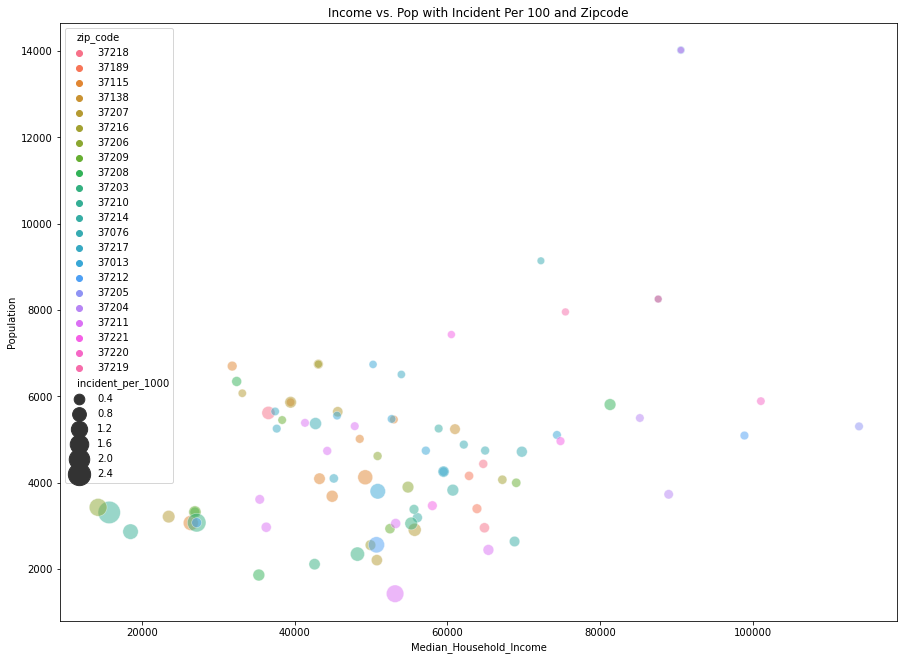

In [151]:
plt.figure(figsize = (15,11))

sns.scatterplot(data = track_MI_Pop, x = 'Median_Household_Income', y = 'Population',
               hue= 'zip_code', size = 'incident_per_1000', sizes=(50,500), alpha=0.5)
plt.title('Income vs. Pop with Incident Per 100 and Zipcode');

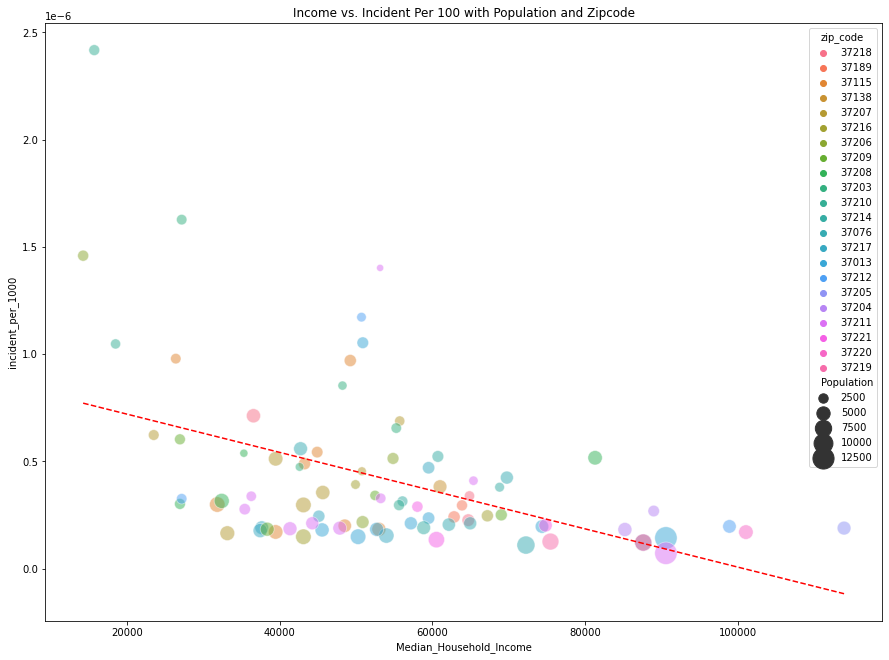

In [154]:
plt.figure(figsize = (15,11))

sns.scatterplot(data = track_MI_Pop, x = 'Median_Household_Income', y = 'incident_per_1000',
               hue= 'zip_code', size = 'Population', sizes=(50,500), alpha=0.5)
x = np.linspace(track_MI_Pop['Median_Household_Income'].min(), track_MI_Pop['Median_Household_Income'].max(), 100)
z = np.polyfit(track_MI_Pop['Median_Household_Income'], track_MI_Pop['incident_per_1000'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--");
plt.title('Income vs. Incident Per 100 with Population and Zipcode');

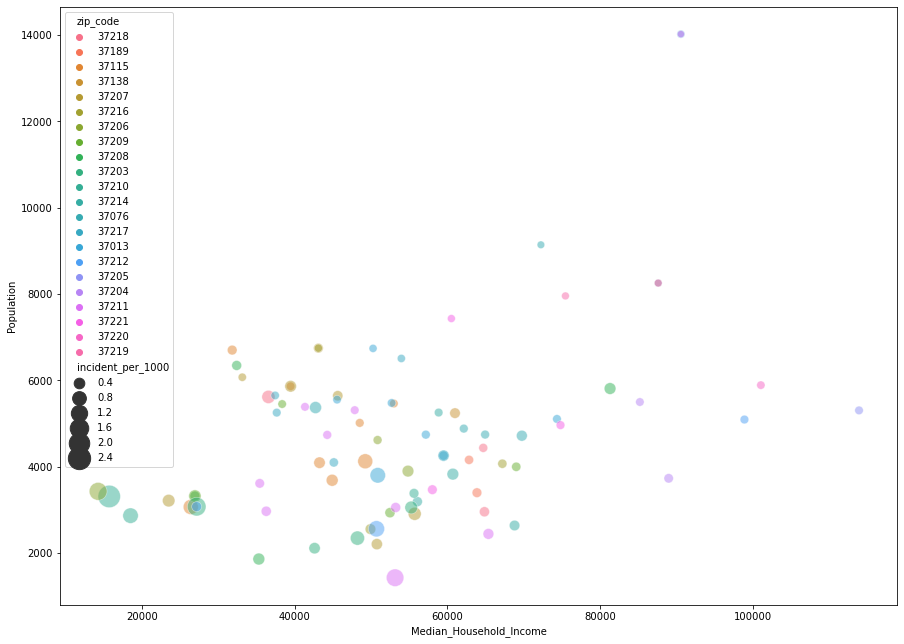

In [161]:
plt.figure(figsize = (15,11))

sns.scatterplot(data = track_MI_Pop, x = 'Median_Household_Income', y = 'Population',
               hue= 'zip_code', size = 'incident_per_1000', sizes=(50,500), alpha=0.5)
track_MI_Pop_poisson=(sm.GLM(endog=track_MI_Pop['incident_per_1000'],
                            exog= sm.add_constant(track_MI_Pop['Median_Household_Income']),
                            family= sm.families.Poisson(),
                            offset=np.log(track_MI_Pop['Population']))
                    .fit()
                     )

In [117]:
median_income_pop_burg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 822 entries, 0 to 821
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   primary_key                  822 non-null    object  
 1   incident_number              822 non-null    object  
 2   report_type                  822 non-null    object  
 3   report_type_description      811 non-null    object  
 4   incident_status_code         822 non-null    object  
 5   incident_status_description  822 non-null    object  
 6   investigation_status         822 non-null    object  
 7   incident_occurred            822 non-null    object  
 8   incident_reported            822 non-null    object  
 9   incident_location            820 non-null    object  
 10  latitude                     822 non-null    float64 
 11  longitude                    822 non-null    float64 
 12  rpa                          765 non-null    object  
 1

In [114]:
median_income_pop_burg['Population'].unique()

array(['945', '4717', '3074', '2313', '1860', '0', '3054', '3428', '8254',
       '2099', '2560', '2980', '3310', '3997', '3335', '2955', '5863',
       '4519', '4157', '3320', '6746', '5810', '4841', '3066', '5726',
       '5014', '4125', '3685', '6740', '7956', '6072', '6701', '4408',
       '3247', '14022', '7432', '5001', '3925', '2442', '3730', '5650',
       '4992', '3665', '2459', '2024', '5386', '2908', '5240', '5942',
       '5309', '4998', '2700', '5463', '7222', '5476', '4363', '6517',
       '3773', '3197', '3800', '2466', '4098', '1427', '5616', '1704',
       '7127', '3619', '2865', '2111', '4744', '2932', '5164', '4256',
       '1617', '4628', '3843', '6345', '2967', '6456', '4742', '5553',
       '5451', '5254', '3613', '4646', '6024', '5971', '5643', '4435',
       '3827', '12176', '4736', '3897', '3743', '5365', '2525', '7262',
       '5092', '4037', '3330', '2637', '4041', '4187', '6406', '7324',
       '4617', '5304', '2345', '3213', '4500', '4313', '5252', '3820',


In [ ]:
plt.figure(figsize = (20,16))

sns.scatterplot(data = median_income_pop_burg, x = 'Median_Household_Income', y = 'Population',
                hue = 'zipcode', palette = 'Blues')
plt.title('Income vs. Pop with Zip');

In [ ]:
median_income_pop_burg.info()

In [ ]:
median_income_pop_burg[['Population', 'Median_Household_Income', 'incident_reported']]